# Forecasting Mini-Course Sales using ETNA with only 60 lines of code 🌋

In [2]:
!pip install etna==2.1.0 -q

<a href="https://github.com/tinkoff-ai/etna">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white"  align='left'>
</a>

In this notebook we will make baseline predictions for [Forecasting Mini-Course Sales](https://www.kaggle.com/competitions/playground-series-s3e19/overview) with [etna time series library](https://github.com/tinkoff-ai/etna/) writing just 60 lines of code.

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
HORIZON = 365

## Dataset

Let's load data in `TSDataset` format. You can check [Get started](https://github.com/tinkoff-ai/etna/tree/master#get-started) tutorial to get familiar with library interface.

In [5]:
from etna.datasets import TSDataset

In [6]:
def load_dataset():
    train = pd.read_csv(TRAIN_PATH, parse_dates=["date"])
    # Rename columns to fit the ETNA format
    data = train.drop(columns=["id"]).rename(columns={"date": "timestamp", "num_sold": "target"})
    # create segment column
    data["segment"] = data["country"].astype(str) + "_" + data["store"].astype(str) + "_" + data["product"]
    # Dataframe with targets
    df = TSDataset.to_dataset(data[["timestamp", "segment", "target"]])
    ts = TSDataset(df=df, freq="D")
    return ts

In [7]:
ts = load_dataset()

First of all, some basic information about the series in the dataset.

In [8]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
Argentina_Kagglazon_Using LLMs to Improve Your Coding,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Argentina_Kagglazon_Using LLMs to Train More LLMs,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Argentina_Kagglazon_Using LLMs to Win Friends and Influence People,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Argentina_Kagglazon_Using LLMs to Win More Kaggle Competitions,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Argentina_Kagglazon_Using LLMs to Write Better,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
...,...,...,...,...,...,...,...,...,...
Spain_Kaggle Store_Using LLMs to Improve Your Coding,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Spain_Kaggle Store_Using LLMs to Train More LLMs,2017-01-01,2021-12-31,1826,0,75,0,0,0,D
Spain_Kaggle Store_Using LLMs to Win Friends and Influence People,2017-01-01,2021-12-31,1826,0,75,0,0,0,D


As we can see, we have 75 unique daily time series, there are no missing values in them. They start on "2017-01-01" and end on "2021-12-31".

## Visualization of some time-series

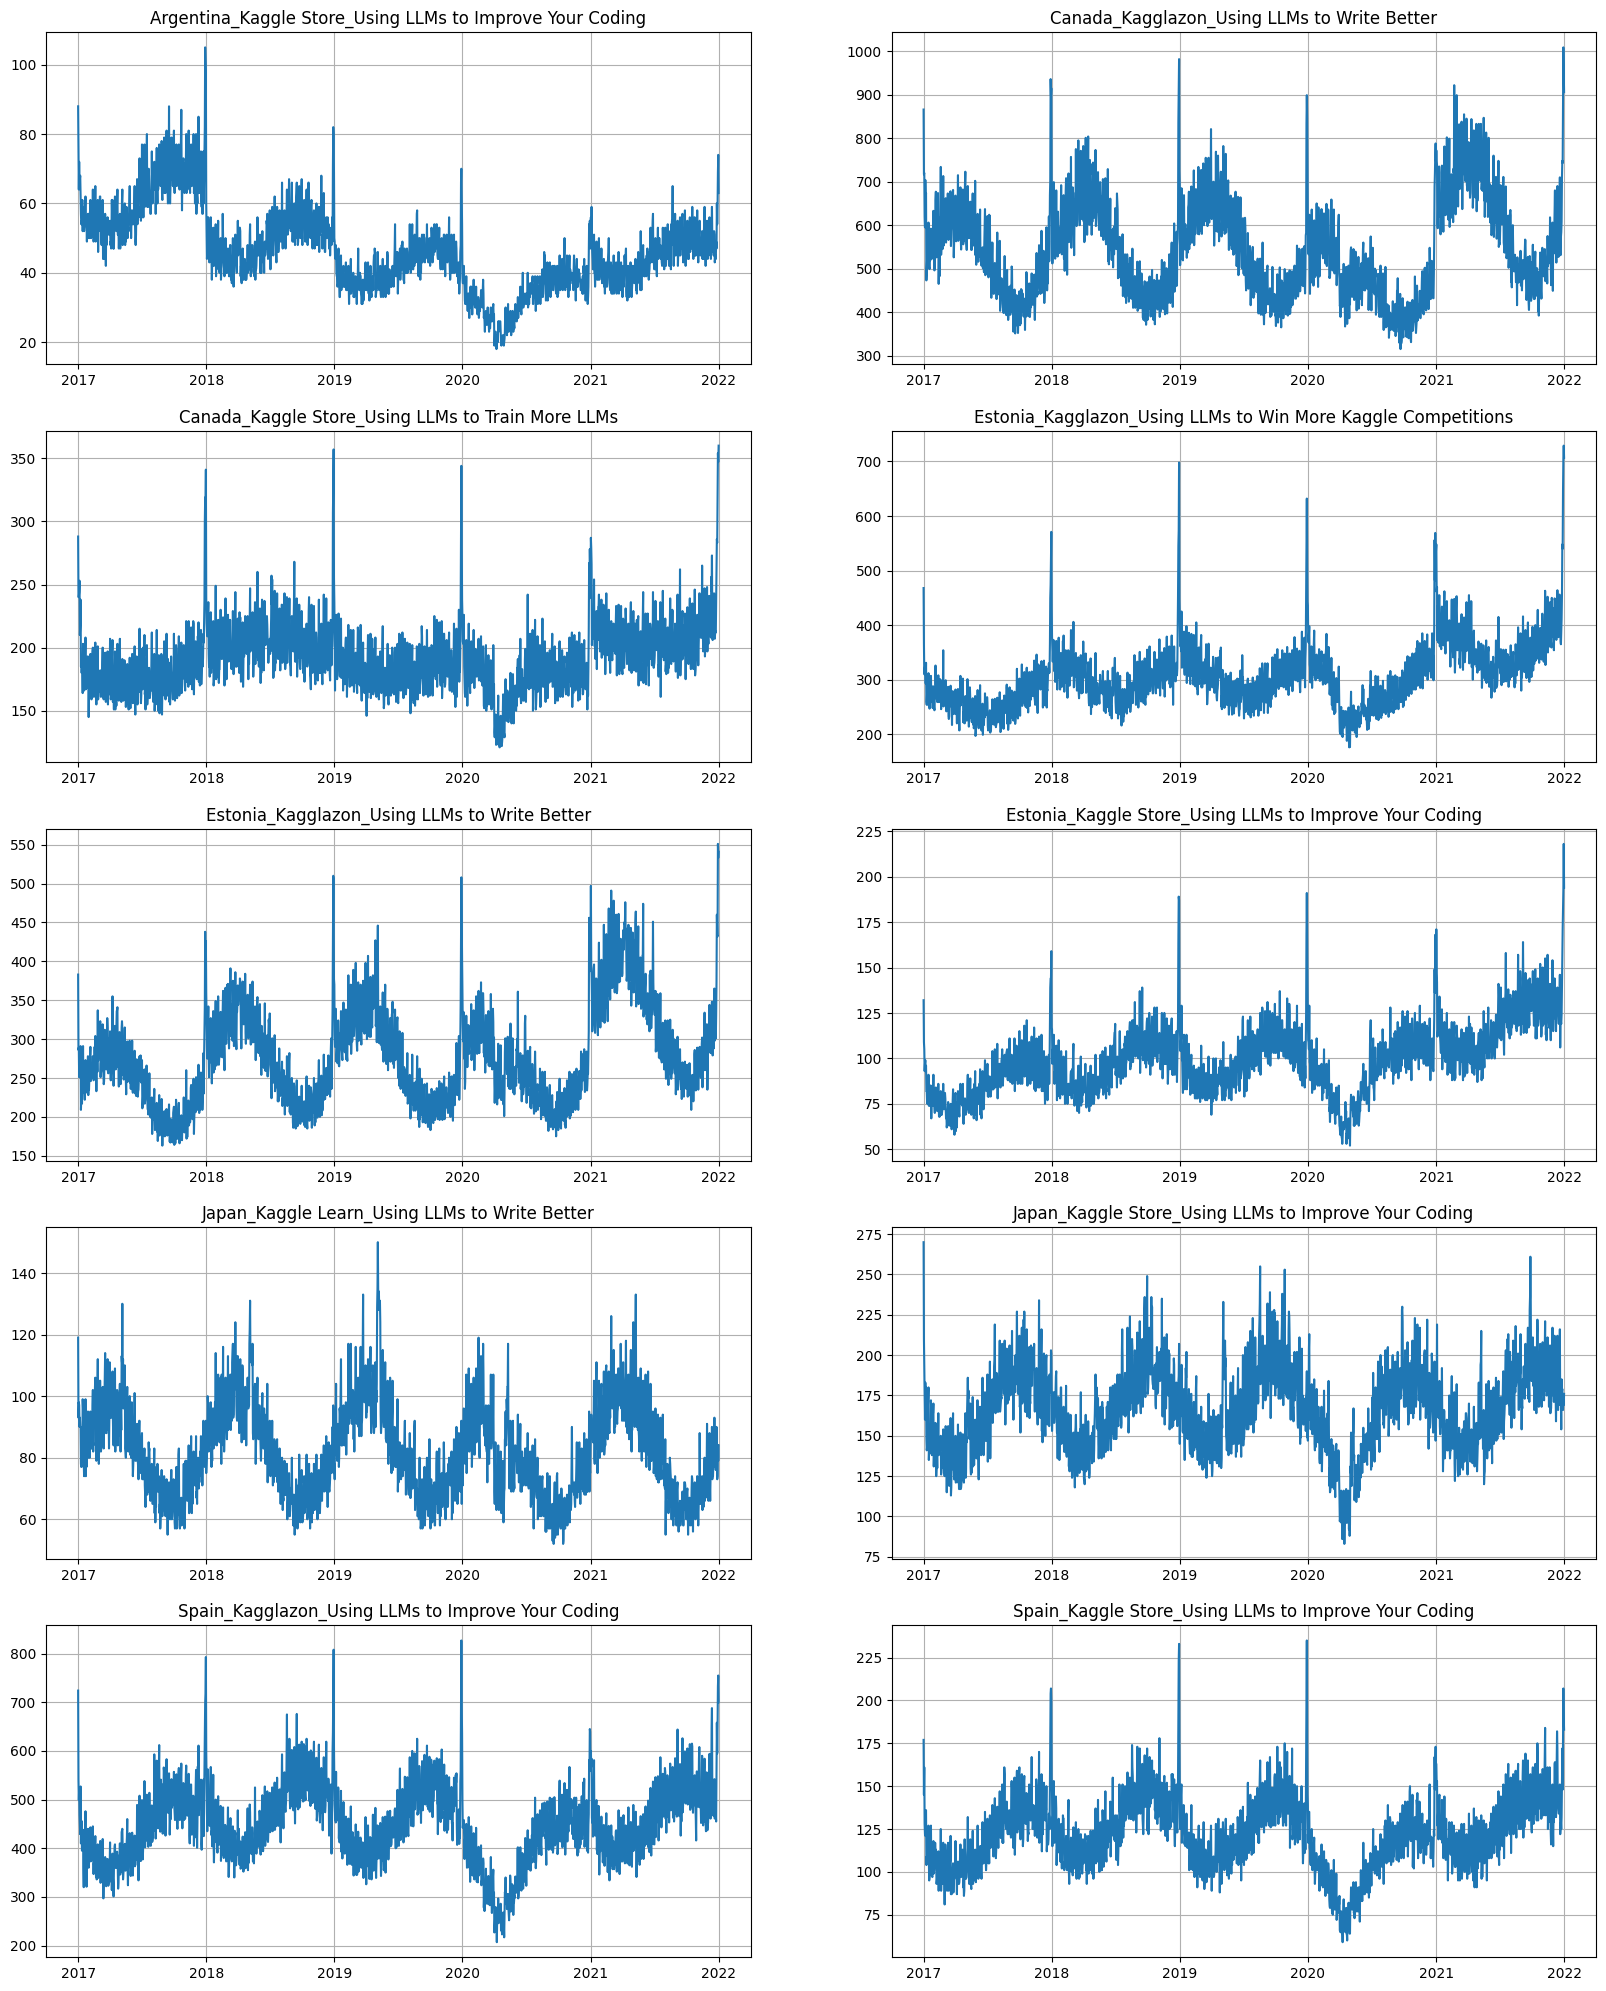

In [ ]:
ts.plot(n_segments=10)

## Backtest

The important part in any project is correct validation. We use 2019 and 2021 years to estimate model performance (we skip 2020 due to covid19). 

In [10]:
from etna.models import CatBoostMultiSegmentModel
from etna.analysis import plot_backtest
from etna.pipeline import FoldMask
from etna.pipeline import Pipeline
from etna.transforms import (
    StandardScalerTransform,
    DateFlagsTransform,
    SegmentEncoderTransform,
    HolidayTransform,
)
from etna.metrics import SMAPE

In [11]:
transforms = [
    SegmentEncoderTransform(),
    StandardScalerTransform(in_column="target"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=False,
        week_number_in_year=True,
        month_number_in_year=True,
        year_number=False,
        is_weekend=True,
        out_column="df",
    ),
]
transforms += [
    HolidayTransform(iso_code=iso_code, out_column=f"{iso_code}_holidays")
    for iso_code in ["AR", "CA", "JP", "ES", "EE"]
]

In [12]:
# folds to estimate model perfomance
fold_masks = [
    FoldMask(
        first_train_timestamp=None,
        last_train_timestamp="2018-12-31",
        target_timestamps=list(pd.date_range(start="2019-01-01", end="2019-12-31", freq="D")),
    ),
    FoldMask(
        first_train_timestamp=None,
        last_train_timestamp="2020-12-31",
        target_timestamps=list(pd.date_range(start="2021-01-01", end="2021-12-31", freq="D")),
    ),
]

In [13]:
pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(random_seed=10),
    transforms=transforms,
    horizon=HORIZON,
)

In [14]:
metrics, forecast, _ = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=fold_masks, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


We got SMAPE = 11.8%, it's pretty good result for baseline.

In [15]:
# mean metric value on 2019 and 2021
metrics.mean()["SMAPE"]

11.798897562576604

We visualize predictions for 2021.

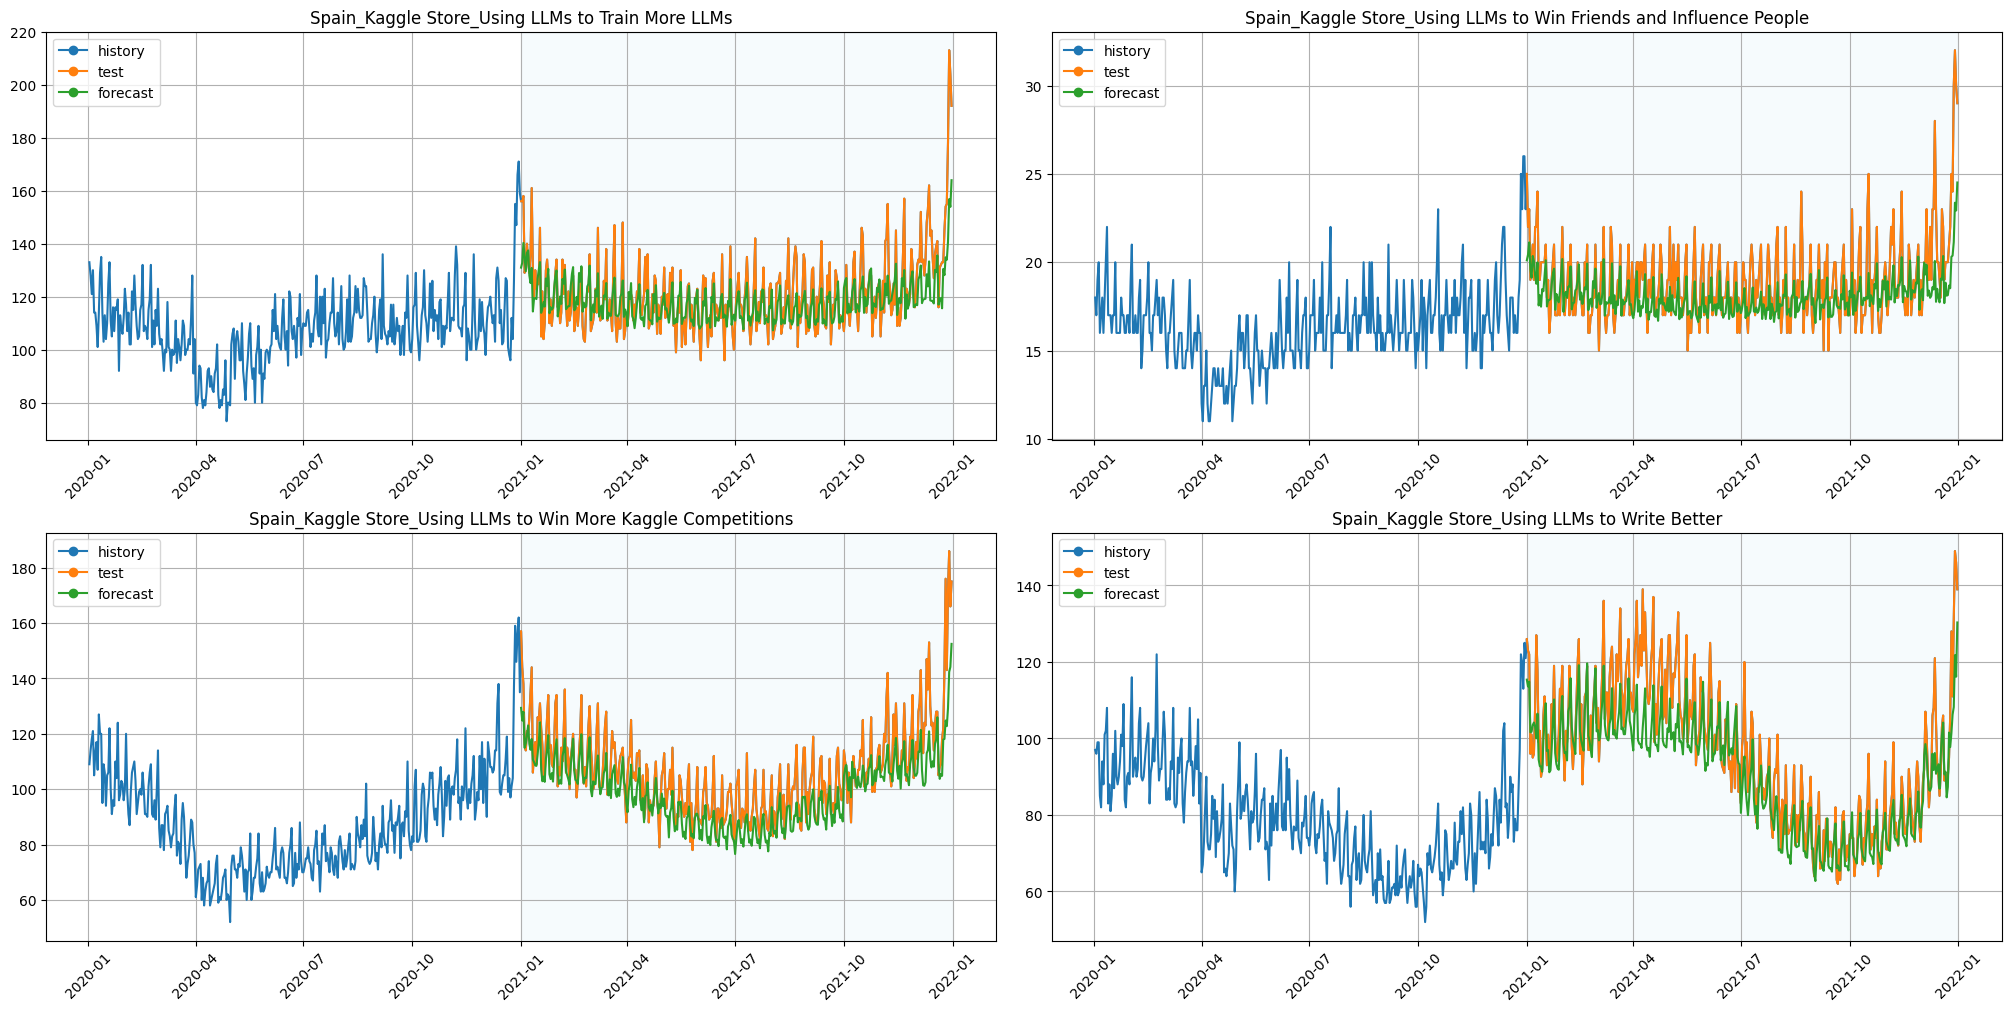

In [16]:
plot_backtest(forecast.tail(HORIZON), ts, history_len=HORIZON, segments=ts.segments[-4:])

## Forecast

In [17]:
from etna.analysis import plot_forecast

In [18]:
ts = load_dataset()
pipeline = Pipeline(model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON)
pipeline.fit(ts=ts)
forecast = pipeline.forecast()

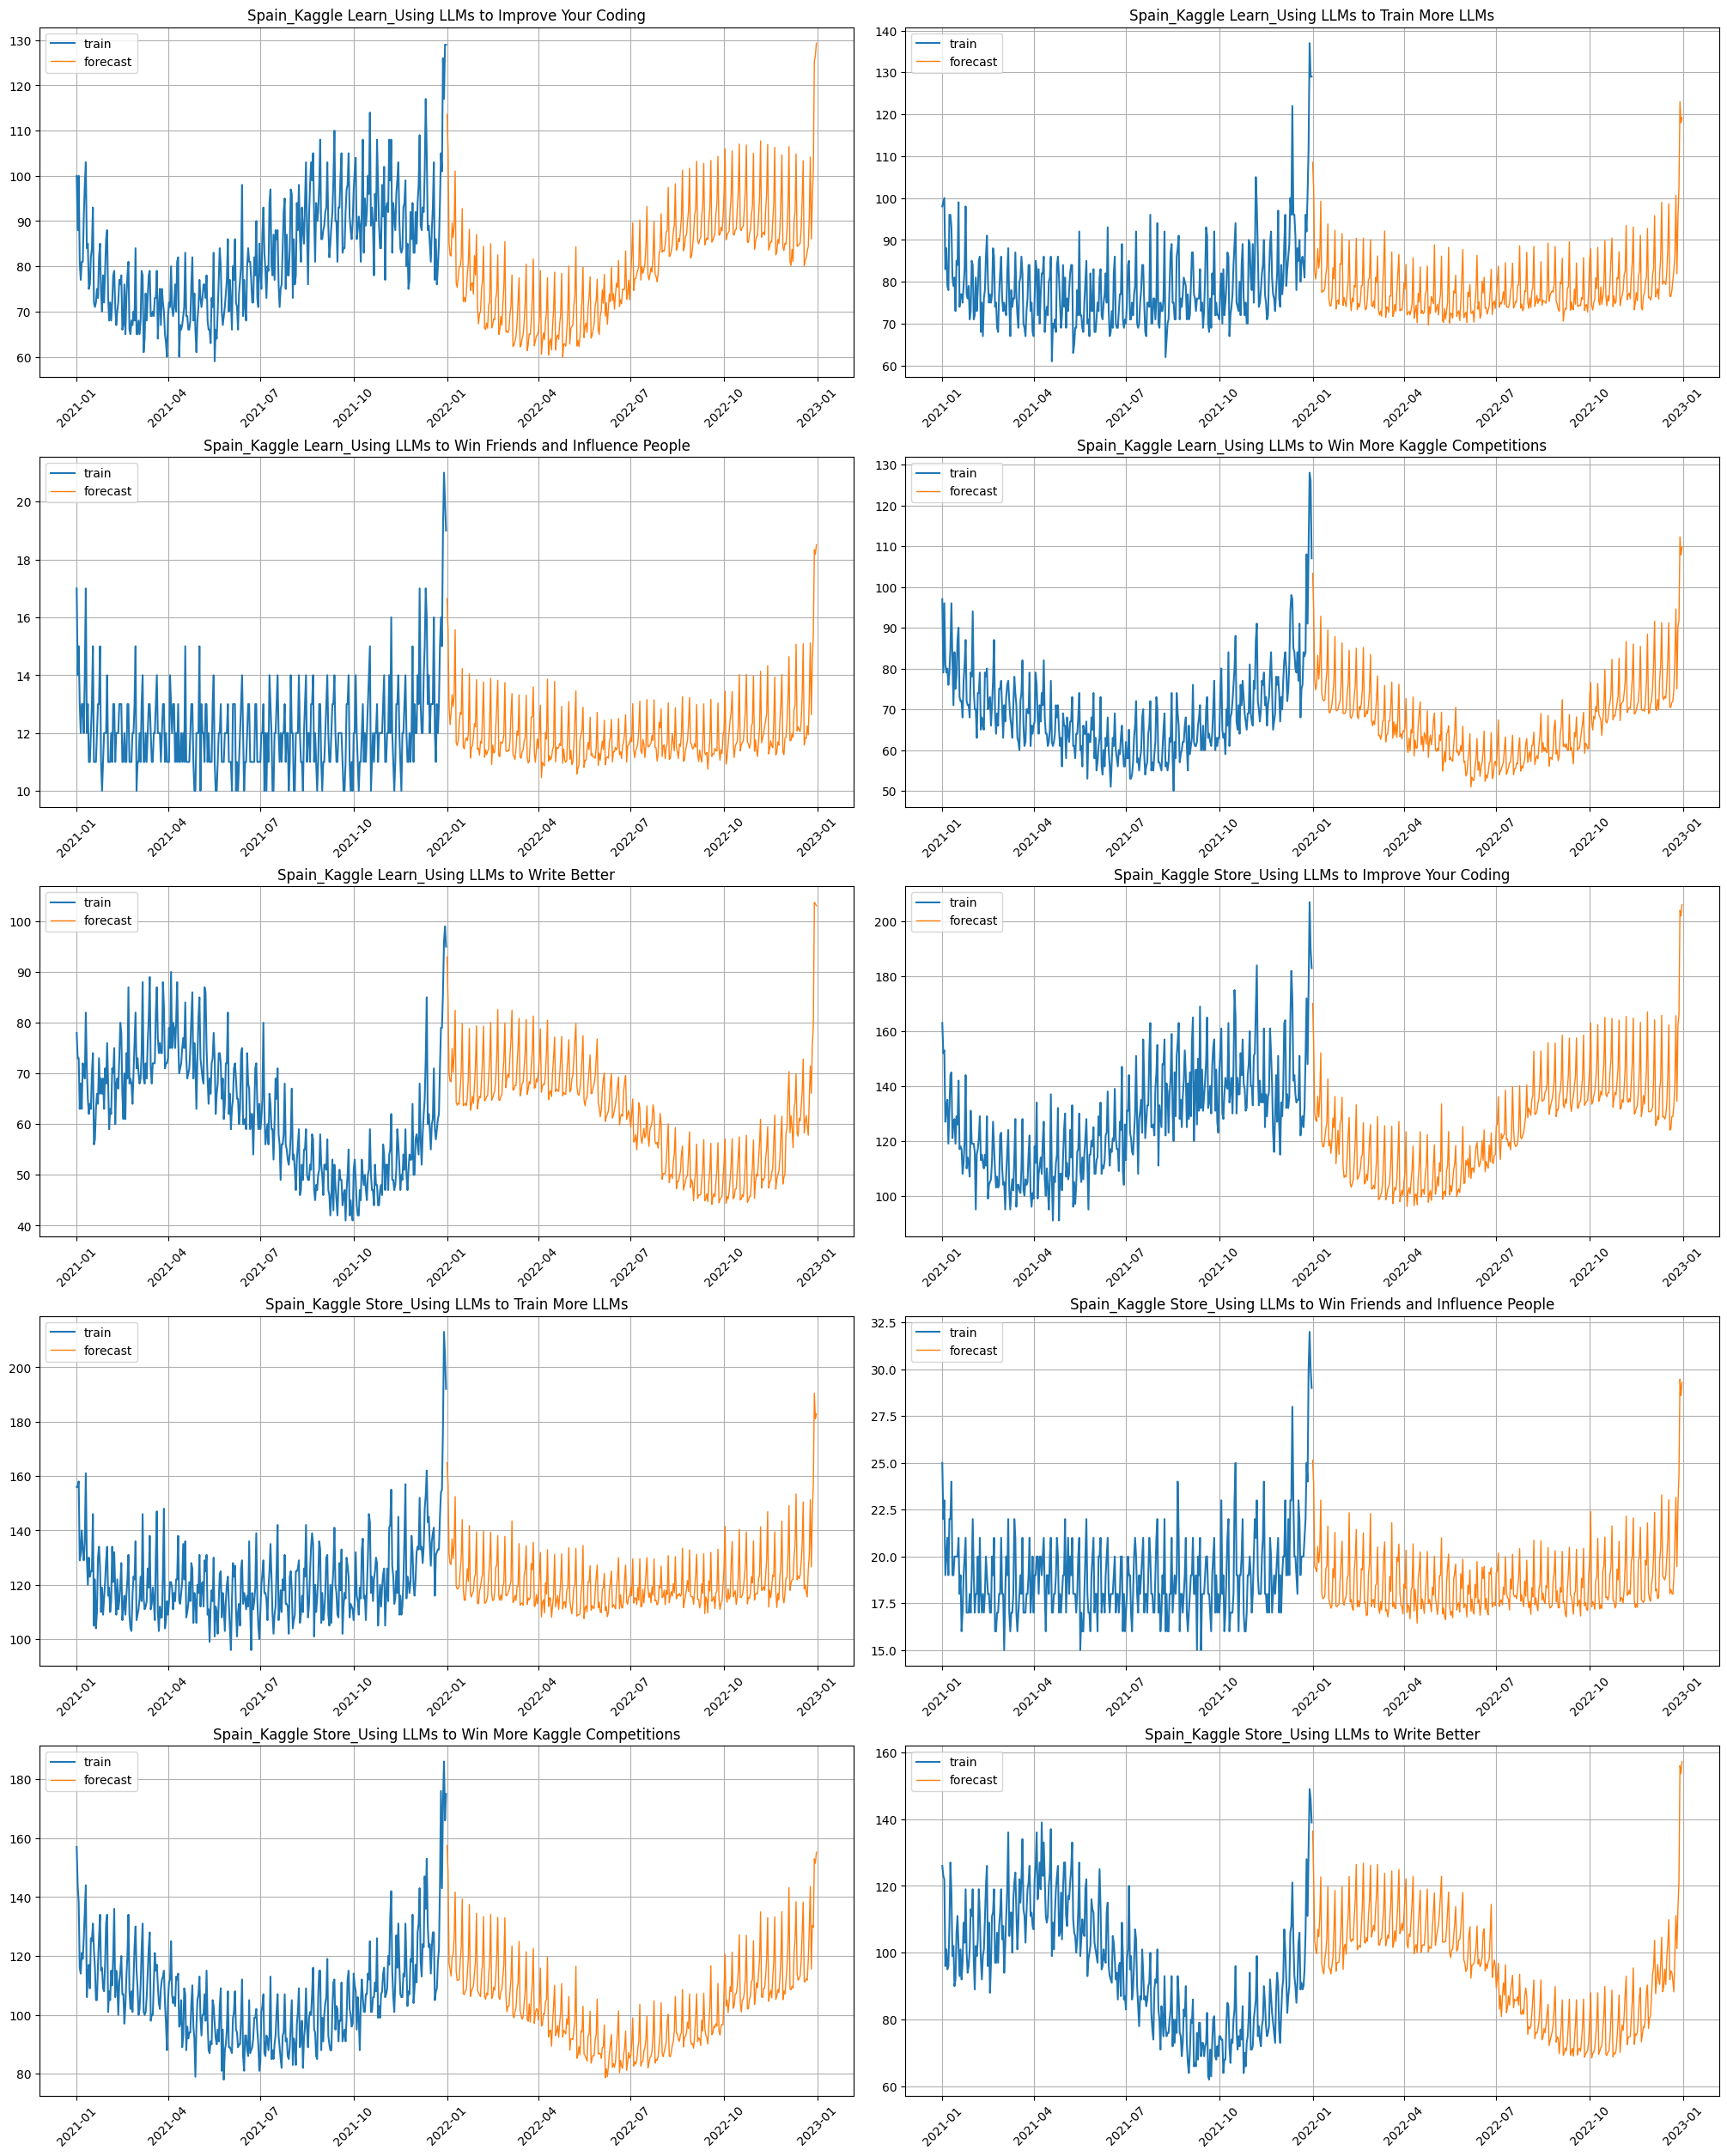

In [19]:
plot_forecast(forecast_ts=forecast, train_ts=ts, n_train_samples=HORIZON, segments=ts.segments[-10:])

## Full pipeline with building submission file

In [20]:
import pandas as pd

from etna.datasets import TSDataset
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import StandardScalerTransform
from etna.transforms import HolidayTransform
from etna.transforms import DateFlagsTransform
from etna.transforms import SegmentEncoderTransform


TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
HORIZON = 365  # prediction size


def load_dataset():
    train = pd.read_csv(TRAIN_PATH, parse_dates=["date"])
    # Rename columns to fit the ETNA format
    data = train.drop(columns=["id"]).rename(columns={"date": "timestamp", "num_sold": "target"})
    # create segment column
    data["segment"] = data["country"].astype(str) + "_" + data["store"].astype(str) + "_" + data["product"]
    # Dataframe with targets
    df = TSDataset.to_dataset(data[["timestamp", "segment", "target"]])
    ts = TSDataset(df=df, freq="D")
    return ts


def make_submission_file(forecast):
    test = pd.read_csv(TEST_PATH)
    forecast_df = forecast.to_pandas(flatten=True)[["timestamp", "segment", "target"]]
    forecast_df[["country", "store", "product"]] = forecast_df["segment"].str.split("_", expand=True)
    forecast_df = forecast_df.rename({"timestamp": "date", "target": "num_sold"}, axis=1)
    forecast_df["date"] = forecast_df["date"].astype(str)
    test = test.merge(
        forecast_df[["date", "country", "store", "product", "num_sold"]],
        on=["date", "country", "store", "product"],
    )[["id", "num_sold"]]
    test.to_csv("submission.csv", index=False)


def submission_pipeline(random_seed=1):
    # load data in TSDataset format
    ts = load_dataset()
    # etna Transforms, that help to build features
    transforms = [
        SegmentEncoderTransform(),
        StandardScalerTransform(in_column="target"),
        DateFlagsTransform(
            day_number_in_week=True,
            day_number_in_month=True,
            week_number_in_month=False,
            week_number_in_year=True,
            month_number_in_year=True,
            year_number=False,
            is_weekend=True,
            out_column="df",
        ),
    ]
    transforms += [
        HolidayTransform(iso_code=iso_code, out_column=f"{iso_code}_holidays")
        for iso_code in ["AR", "CA", "JP", "ES", "EE"]
    ]
    # define pipeline
    pipeline = Pipeline(
        model=CatBoostMultiSegmentModel(random_seed=random_seed),
        transforms=transforms,
        horizon=HORIZON,
    )
    # fit pipeline
    pipeline.fit(ts=ts)
    # make predictions
    forecast = pipeline.forecast()
    # create submission.csv
    make_submission_file(forecast)

We built the baseline solution with just 60 lines of code using `etna` library.

In [21]:
submission_pipeline(random_seed=10)